In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, ConvLSTM2D, TimeDistributed
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statistics import mean
from itertools import chain

sns.set(style='darkgrid', palette='muted', font_scale=1.5, rc={'figure.figsize':(20,10)})

RANDOM_SEED = 32
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [223]:
def load_data(path, columns, start=None, stop=None):
    df = pd.read_pickle(path)
    return df.loc[start:stop, columns]

In [255]:
df = load_data('../../data/ica_summary.pkl', columns=['artiklar'], stop='2021-03-01')
df

,artiklar
2020-05-04,1016.0
2020-05-05,1317.0
2020-05-06,1027.0
2020-05-07,1572.0
2020-05-08,1509.0
...,...
2021-03-18,3458.0
2021-03-19,4818.0
2021-03-20,1479.0
2021-03-21,0.0


In [225]:
def icas_egna_features(df):
    features = {}

    def add_weekday(features):
        features['weekday'] = pd.Series(df.index.weekday, index=df.index)
    
    def add_day_of_month(features):
        features['day_of_month'] = pd.Series(df.index.day, index=df.index)
    
    def add_before_mini_holiday(features):
        # one day before mini_holiday
        holidays = ['2020-12-31', '2021-01-05', '2021-04-01', '2021-04-03', '2021-04-04', '2020-05-20', '2020-05-30', '2020-06-05', '2020-06-19', '2020-10-30', '2020-12-24', '2020-12-25']
        features['holiday'] = pd.Series(np.where(df.index.isin(holidays), 1, 0), index=df.index)
    
    def add_before_holiday(features):
        features['before_holiday'] = pd.Series(0, index=df.index)
        before_holidays = ['2020-12-30', '2021-04-01', '2020-06-18', '2020-12-23']
        for holiday in before_holidays:
            for j, i in enumerate([3, 2, 1], 1):
                features['before_holiday'][pd.to_datetime(holiday) - pd.DateOffset(j)] = i
    
    def add_payday(features, payday, pension=False):
        if pension:
            if 'pension' not in features:
                features['pension'] = pd.Series(0, index=df.index) 
                series = features['pension']
            else:
                series = features['pension']
                
        if not pension:
            features['payday'] = pd.Series(0, index=df.index)
            series = features['payday']
        
        for i, day in enumerate(features['day_of_month']):
            if day == payday:
                if features['weekday'].iloc[i] in [5, 6] or features['holiday'].iloc[i]:
                    paydays = i - 1 if features['weekday'].iloc[i-1] not in [5, 6] or features['holiday'].iloc[i -1] else i - 2
                    series.iloc[paydays] = 1 
                else:
                    series.iloc[i] = 1
    
    add_weekday(features)
    add_day_of_month(features)
    add_before_mini_holiday(features)
    add_before_holiday(features)
    add_payday(features, 25)
    add_payday(features, 18, pension=True)
    add_payday(features, 17, pension=True)

    return features

In [226]:
features = icas_egna_features(df)
for k, v in features.items():
    print(type(v))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [227]:
def add_basic_combination_feature(df, features):
    df_list = [df]
    for i, feat in enumerate(features, 1):
        ts = df.copy()
        for j in range(i):
            ts[list(features.keys())[j]] = list(features.values())[j]
        df_list.append(ts)
    return df_list

In [244]:
df_list = add_basic_combination_feature(df, features)
df_list = [df_list[-1]]

In [229]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def scale_data(df_list):
    scaled_df_list = []
    for df in df_list:
        standard_scaler_x = StandardScaler()
        standard_scaler_y = StandardScaler()

        scalers = [[standard_scaler_x, standard_scaler_y]]


        for scaler in scalers:
            if len(df.columns) == 1:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'y': scaler[1].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
            else:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:, :].to_numpy()), 
                                       'y': scaler[1].fit_transform(df.iloc[:, 0].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
    
    return scaled_df_list

In [230]:
scaled_data = scale_data(df_list)

In [253]:
def create_time_step(train_test, time_steps):
    time_step_df = []
    for time_step in time_steps:
        for df in train_test:
            new_df = {key: df[key] for key in ['scaler_y', 'scaler_x', 'features']}
            
            X_y = [[df['X'][i: (i + time_step)], df['y'][i + time_step]] for i in range(len(df['X']) - time_step)]
            
            new_df['X'], new_df['y'] = np.array([x for x, _ in X_y]), np.array([y for _, y in X_y])
            new_df['time_steps'] = time_step

            time_step_df.append(new_df)
            
    return time_step_df

In [254]:
time_steps = [7]

time_step_df = create_time_step(scaled_data, time_steps)

In [233]:
def split_train_test(scaled_data, test_size):
    
    return [{'X_train': df['X'][:-test_size], 
             'y_train': df['y'][:-test_size],
             'X_test': df['X'][-test_size:],
             'y_test': df['y'][-test_size:],
             'scaler_x': df['scaler_x'],
             'scaler_y': df['scaler_y'],
             'time_steps': df['time_steps'],
             'features': df['features']} 
             for df in scaled_data]

In [234]:
train_test = split_train_test(time_step_df, 7)
print(len(train_test[0]['X_test']))

7


In [235]:
def run_models(list_df):
    best_models = []
    epochs = [25, 25, 25, 25, 25, 25]
    for i, epoch in enumerate(epochs):
        for j, df in enumerate(list_df, 1):
            file_path = f'./fitted_models/{i}_{j}'
            print(file_path)
            
            model = Sequential()
            model.add(Bidirectional(
                      LSTM(units=128, activation='relu', input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])),
                      merge_mode='sum'))
#             model.add(Dropout(0.2))
            model.add(Dense(units=100))
            model.add(Dense(1))
            model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
            
#             model = Sequential()
#             model.add(Bidirectional(
#                       LSTM(return_sequences=True, units=14, activation='relu', input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])),
#                       merge_mode='sum'))
#             model.add(Dropout(0.1))
#             model.add(Bidirectional(
#                       LSTM(return_sequences=True, units=10, activation='relu', input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])),
#                       merge_mode='sum'))
#             model.add(Dropout(0.1))
#             model.add(Bidirectional(
#                       LSTM(units=6, activation='relu', input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])),
#                       merge_mode='sum'))
#             model.add(Dense(units=100))
#             model.add(Dense(1))
#             model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
            
            print(f'Training {i + j}/{len(list_df) * len(epochs)}'.center(50, '-'))
            
            df['y_test'] = df['scaler_y'].inverse_transform(df['y_test'])

            history = model.fit(
                df['X_train'], df['y_train'],
                epochs=epoch,
                batch_size=32,
                validation_data=(df['X_test'], df['scaler_y'].transform(df['y_test'])),
                shuffle=False,
                verbose=2
            )

            df['history'] = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}

            predictions = model.predict(df['X_test'])

            if df['scaler_y']:
                df['predictions'] = df['scaler_y'].inverse_transform(predictions)
            else:
                df['predictions'] = predictions
            
            model.save(file_path)

            best_models.append({
                'model': file_path,
                **df.copy(), 
                **{'score': {
                    'RMSE': np.sqrt(mean_squared_error(y_true=df['y_test'], y_pred=df['predictions'])),
                    'MAE': mean_absolute_error(y_true=df['y_test'], y_pred=df['predictions']),
                    'r2': r2_score(y_true=df['y_test'], y_pred=df['predictions'])}}
            })
            
            df['y_test'] = df['scaler_y'].transform(df['y_test'])

    return best_models

In [236]:
best_models = run_models(train_test)

./fitted_models/0_1
-------------------Training 1/6-------------------
Epoch 1/25
10/10 - 1s - loss: 1.3820 - val_loss: 1.2825
Epoch 2/25
10/10 - 0s - loss: 0.8973 - val_loss: 0.9161
Epoch 3/25
10/10 - 0s - loss: 0.8881 - val_loss: 0.9035
Epoch 4/25
10/10 - 0s - loss: 0.7176 - val_loss: 0.7883
Epoch 5/25
10/10 - 0s - loss: 0.5805 - val_loss: 0.5844
Epoch 6/25
10/10 - 0s - loss: 0.4782 - val_loss: 0.4175
Epoch 7/25
10/10 - 0s - loss: 0.3832 - val_loss: 0.2700
Epoch 8/25
10/10 - 0s - loss: 0.3212 - val_loss: 0.1813
Epoch 9/25
10/10 - 0s - loss: 0.2817 - val_loss: 0.1390
Epoch 10/25
10/10 - 0s - loss: 0.2516 - val_loss: 0.1130
Epoch 11/25
10/10 - 0s - loss: 0.2169 - val_loss: 0.0709
Epoch 12/25
10/10 - 0s - loss: 0.1849 - val_loss: 0.0434
Epoch 13/25
10/10 - 0s - loss: 0.1670 - val_loss: 0.0710
Epoch 14/25
10/10 - 0s - loss: 0.1733 - val_loss: 0.2299
Epoch 15/25
10/10 - 0s - loss: 0.1866 - val_loss: 0.2063
Epoch 16/25
10/10 - 0s - loss: 0.1608 - val_loss: 0.0434
Epoch 17/25
10/10 - 0s - l

In [237]:
for d in best_models:
    print(d['score'])

{'RMSE': 166.29858673596567, 'MAE': 131.01176670619526, 'r2': 0.9865756160536701}
{'RMSE': 229.8765416564947, 'MAE': 174.06781441824884, 'r2': 0.9743488667009872}
{'RMSE': 319.06100402889956, 'MAE': 230.34395490373953, 'r2': 0.950584328316527}
{'RMSE': 290.14900415373125, 'MAE': 211.82749285016848, 'r2': 0.9591342553930983}
{'RMSE': 287.5812581047896, 'MAE': 193.03747122628417, 'r2': 0.9598543580852364}
{'RMSE': 263.2835242138706, 'MAE': 189.06183297293634, 'r2': 0.9663515848898081}


In [238]:
def show_results(df_list, rows=3):
    best_df = np.array(sorted(df_list, key=lambda df: df['score']['r2'], reverse=True)[:rows * 3]).reshape(rows, 3)

    fig_1, ax_1 = plt.subplots(rows, best_df.shape[1], figsize=(25, rows * 5))
    fig_1.suptitle('Loss / Val_loss', size=30)

    for i, row in enumerate(ax_1):
        for j, col in enumerate(row):
            col.set_title(f'R2: {best_df[i][j]["score"]["r2"]:0.4f} RMSE: {best_df[i][j]["score"]["RMSE"]:0.2f} MAE: {best_df[i][j]["score"]["MAE"]:0.2f}', size=15)
            col.plot(best_df[i][j]['history']['loss'], label='train')
            col.plot(best_df[i][j]['history']['val_loss'], label='validation')
            col.legend(loc="upper right", prop={'size': 12})
            col.tick_params(labelsize=12)
    
    fig_2, ax_2 = plt.subplots(best_df.shape[0], best_df.shape[1], figsize=(25, rows * 5))
    fig_2.suptitle('1 week predictions', size=30)

    for i, row in enumerate(ax_2):
        for j, col in enumerate(row):
            col.set_title(f'R2: {best_df[i][j]["score"]["r2"]:0.4f} RMSE: {best_df[i][j]["score"]["RMSE"]:0.2f} MAE: {best_df[i][j]["score"]["MAE"]:0.2f}', size=15)
            col.plot(best_df[i][j]['y_test'], label='true', marker=".")
            col.plot(best_df[i][j]['predictions'], label='predicted', marker=".")
            col.legend(loc="upper right", prop={'size': 12})
            col.tick_params(labelsize=12)

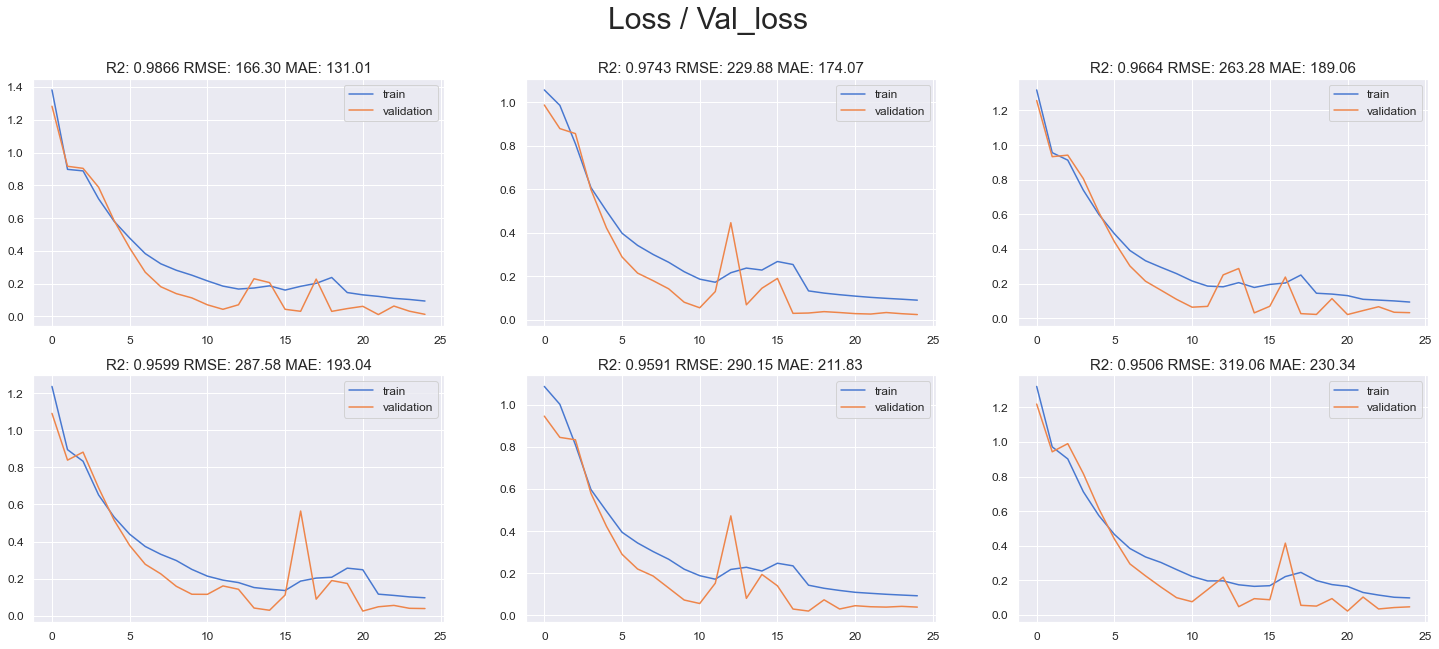

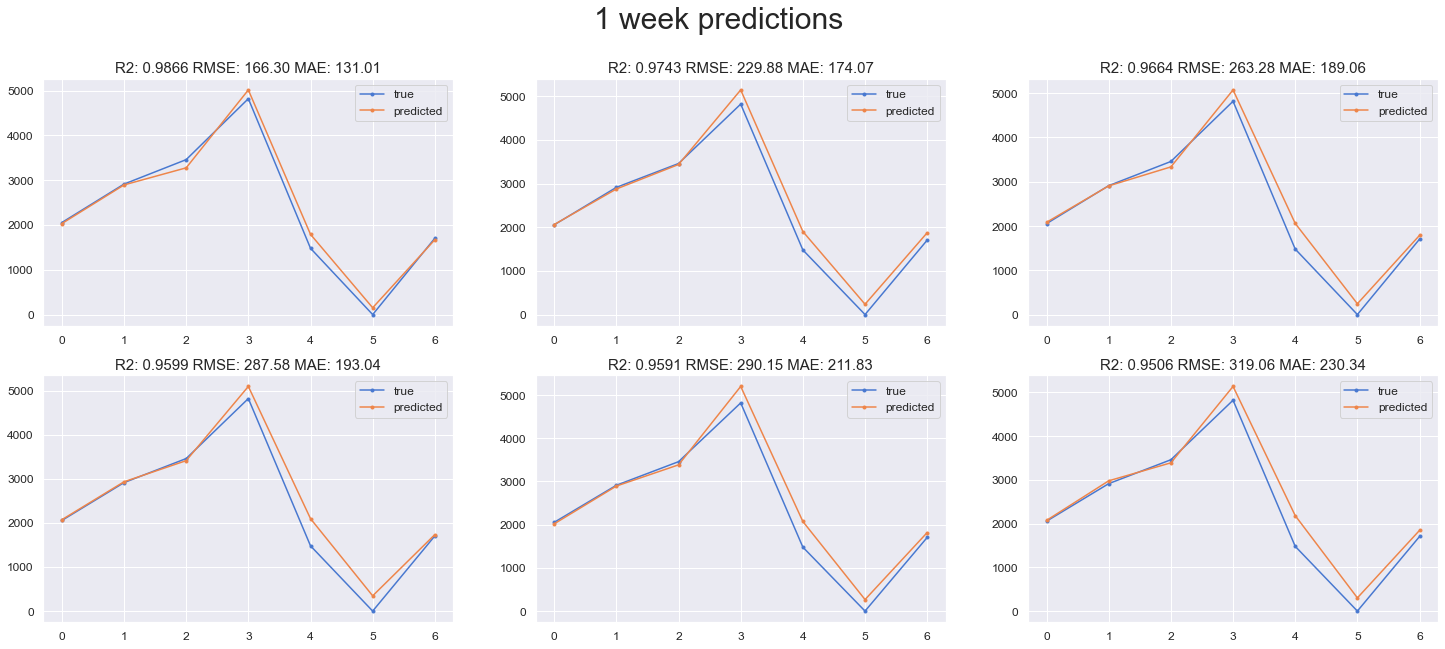

In [239]:
show_results(best_models, 2)

In [102]:
import pickle
def save_results(df_list, name):
    with open(f'./fitted_models/{name}.pkl', 'wb') as f:
        pickle.dump(df_list, f)

In [103]:
save_results(best_models, 'fitted_models')